# Image segmentation
This notebook will cover some of the image segmentation method introduced in TDT4195.

In [1]:
#Imports
import numpy as np
from matplotlib import pyplot as plt

## Boundary based methods

### Canny-edge detector
This section will demonstrate how to apply Open CV's implementation of canny-edge detector. The documentation can be found [here](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html) and a short tutorial can be found [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html).

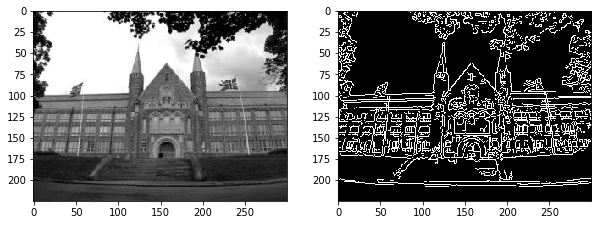

In [2]:
import cv2
image = plt.imread("images/gloshaugen.jpg")
image = np.dot(image, [0.2989, 0.5870, 0.1140])
image = image.astype(np.uint8)
edges = cv2.Canny(image, threshold1 = 50, threshold2 = 200)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(edges, cmap = "gray")
plt.show()

### Hough transform

Hough transform is a feature extracting method for extracting simple features such as lines, circles or polygons. The algorithm transforms each point in an image into hough-space. A point in image space is a sinusoidal curve in the hough-space. Similarly, a point in hough-space is a line in the image-space. Thus, since a line consists of many points, the sinusoidals corresponding to each point in a line will intersect in the point in hough-space that correspond to that line.

This notebook will demonstrate an implementation of the hough-transform for line-detection. This is for educational purposes only, normally you would not need to implement the hough-transform yourself. Open CV, for instance, has available implementations that you can use. A guide for hough-transform with Open CV can be found [here](https://livecodestream.dev/post/2020-05-26-hough-transformation/).

#### Generating the voting table
Hough-space is a 2d-space, and thus the voting table is a two-dimensional array. For this implementation it was chosen to let $\theta$ run through the x-axis and $\rho$ through the y-axis.

The x-axis is divided into a fixed number of steps, where index 0 represents $- \frac{\pi}{2}$, and the max index represents $\frac{\pi}{2}$.

The y-axis is also normaly divided into a fixed number of steps, but for simplicity this implementation chose to let the values range from $x[0] = \rho_{min}$ to $x[len(x)-1] = \rho_{max}$

To transform an x, y pair into hough-space we run through all possible $\theta$ values between $- \frac{\pi}{2}$ and $\frac{\pi}{2}$ and calculate the corresponding $\rho$.

$$\rho = x \cos{\theta} + y \sin{\theta}$$

In [3]:
def generate_hough_table(im: np.ndarray, steps = 256):
    rho_max = np.sqrt(im.shape[0]**2 + im.shape[1]**2)
    rho_min = -im.shape[0]
    #Initialize voting table
    hough = np.zeros((int(rho_max-rho_min), steps))
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if im[y,x]:
                #Vectorization of theta, rho calculation with numpy
                theta = np.linspace(-np.pi/2,np.pi/2,steps)
                rho = x*np.cos(theta) + y*np.sin(theta)
                #For each possible theta increment corresponding rho
                for r,t in zip(rho, range(steps)):
                    hough[int(r - rho_min), t] += 1
    return hough

#### Recovering lines from voting table
To recover the lines from the voting table we must find the cells with high number of votes in the hough table. This implementation has chosen to simply threshold the image. A better method would look for local maximums and suppress neightboring maximums.

Once we have found the x,y values in the hough table that correspond to lines in image space, we can recover the rho and theta. When we know rho and theta, we can draw lines by solving the transformation equation for y:
$$ y = \frac{\rho - x \cos{\theta}}{\sin{\theta}}$$

In [4]:
def hough_table_to_rho_theta(x, y, im_shape, steps=256):
    thetas = np.linspace(-np.pi/2,np.pi/2,steps)
    theta = thetas[x]
    rho = y - im_shape[0]
    return rho, theta


def find_lines(hough_table, im_shape, threshold, steps = 256):
    line_image = np.zeros(im_shape)
    for h_y in range(hough_table.shape[0]):
        for h_x in range(hough_table.shape[1]):
            # Chech if number of votes are more than the threshold
            if hough_table[h_y,h_x] >= threshold:
                #Recover rho and theta from x, y in hough_table
                rho, theta = hough_table_to_rho_theta(h_x, h_y, im_shape, steps)
                for line_x in range(im_shape[1]):
                    line_y = (rho - line_x*np.cos(theta))/np.sin(theta)
                    if(line_y < im_shape[0] and line_y > 0):
                        line_image[int(line_y), line_x] += 1
    return line_image

#### Bringing it all together
Normally we run hough-transform over edge images, for instance the output of a canny-edge detector. For educational purposes, this notebook demonstrates hough transform on discontinous lines. 

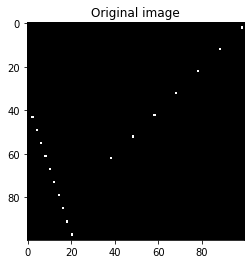

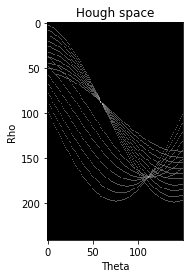

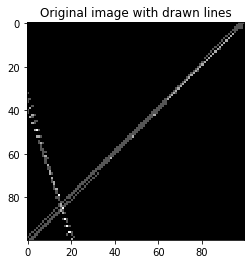

In [5]:
import random
def generate_image():
    im = np.zeros((100, 100))
    for i in range(1,70,10):
        im[i+1, 100-(i+1)] = 1

    for i in range(1,20,2):
        im[3*i+40, (i+1)] = 1

    #for i in range(1, 20, 3):
    #    im[2*i, 3*i] = 1
    
    #Add some noise
    #for i in range(10):
    #    im[random.randint(0,99), random.randint(0,99)] = 1
    return im.astype(np.uint8)

im = generate_image()
plt.figure()
plt.imshow(im, cmap = "gray")
plt.title("Original image")
plt.show()

hough_table = generate_hough_table(im, steps = 150)

plt.figure()
# Gamma transform hough-image for better visibility
plt.imshow((hough_table/np.max(hough_table))**0.5, cmap = "gray")
plt.title("Hough space")
plt.xlabel("Theta")
plt.ylabel("Rho")
plt.show()


line_image = find_lines(hough_table, im.shape, threshold = 4, steps = 150)


plt.figure()
plt.imshow(im + line_image, cmap = "gray")
plt.title("Original image with drawn lines")
plt.show()

### Exercise
Apply canny edge detector on the following image. Then use hough transform to generate lines, and impose them on the original image. If you understood the algorithm from the python implementation above, feel free to try out [Open CV's implementation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#houghlines) instead.

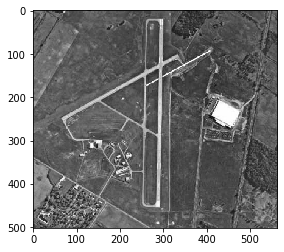

In [6]:
image = plt.imread("images/airport.tif")
plt.imshow(image, cmap = "gray")
plt.show()

#### Example solution

##### Generating edge image
We start by generating an edge-image from the original image with Open CV's Canny edge detector.

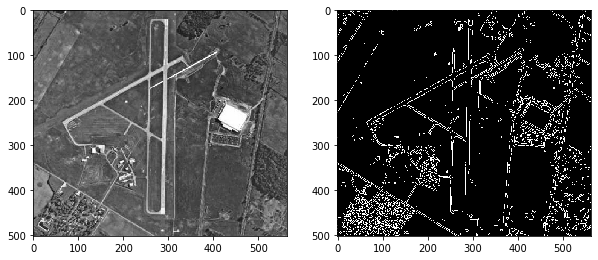

In [7]:
image = plt.imread("images/airport.tif")

edges = cv2.Canny(image, threshold1 = 150, threshold2 = 210)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(edges, cmap = "gray")
plt.show()

##### Drawing hough lines with open CV

In [8]:
def impose_lines_on_gray_image(gray_image, line_mask):
    color_image = np.zeros((gray_image.shape[0], gray_image.shape[1],3), dtype = np.uint8)
    color_image[:,:,0] = gray_image
    color_image[:,:,1] = gray_image
    color_image[:,:,2] = gray_image


    color_image[line_mask] = [255,0,0]
    return color_image

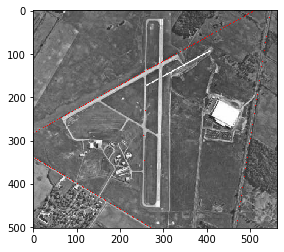

In [9]:
#Open CV's implementation returns a list of rho's and theta's
steps = 180
threshold = 200
lines = cv2.HoughLines(edges, 1, np.pi/steps, threshold)

# Draw lines on the image
line_image = np.zeros_like(image, dtype = bool)
for line in lines:
    rho, theta = line[0]
    for line_x in range(image.shape[1]):
        if(np.sin(theta) != 0):
            line_y = (rho - line_x*np.cos(theta))/np.sin(theta)
            if(line_y < image.shape[0] and line_y > 0):
                line_image[int(line_y), line_x] = True

color_image = impose_lines_on_gray_image(image, line_image)
plt.imshow(color_image)
plt.show()

##### Drawing hough lines with python implementation

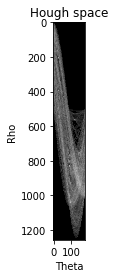

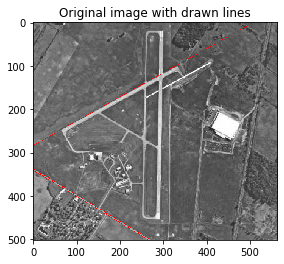

In [10]:
steps = 180
threshold = 200
hough_table = generate_hough_table(edges, steps)

plt.figure()
# Gamma transform hough-image for better visibility
plt.imshow((hough_table/np.max(hough_table))**0.5, cmap = "gray")
plt.title("Hough space")
plt.xlabel("Theta")
plt.ylabel("Rho")
plt.show()

line_image = find_lines(hough_table, image.shape, threshold, steps).astype(bool)
color_image = impose_lines_on_gray_image(image, line_image)

plt.figure()
plt.imshow(color_image, cmap = "gray")
plt.title("Original image with drawn lines")
plt.show()

## Region based methods

### Thresholding
A very simple segmentation method is to threshold the image. This can be done with greyscale images by thresholding the intensity value. In color images one can threshold individual color channels or threshold on a comparison of the color channels.

#### Intuition
This code demonstrates how we can get quick, and simple results from thresholding. Later topics will discuss how to find optimal threshold values based on statistics.

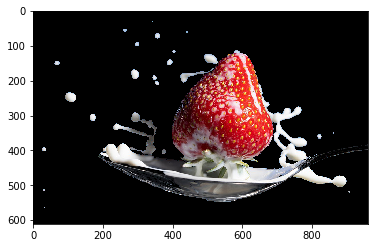

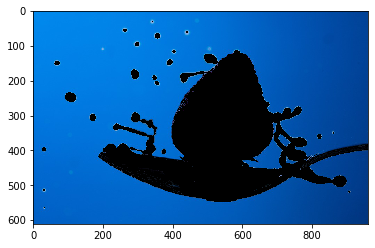

In [11]:
image_path = "images/strawberry.jpg"
image = plt.imread(image_path)


result = np.zeros_like(image)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        #Set the pixel to black if blue is the dominant color
        result[y,x,:] = image[y,x,:] if image[y,x,0]**2 + image[y,x,1]**2 > image[y,x,2]**2 else [0,0,0]
plt.imshow(result)
plt.show()

result = np.zeros_like(image)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        result[y,x,:] = image[y,x,:] if image[y,x,0]**2 + image[y,x,1]**2 < image[y,x,2]**2 else [0,0,0]
plt.imshow(result)
plt.show()

#### Supervised thresholding
With the following image, try to find a threshold value that keeps only the text.

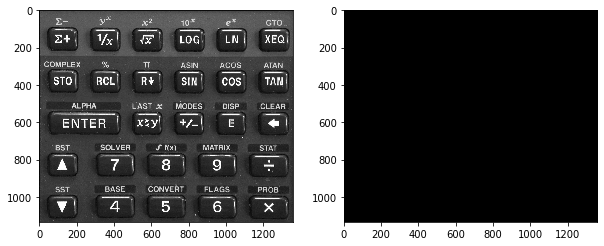

In [12]:
image = plt.imread("images/calculator.tif")
image_mask = image > 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(image_mask, cmap = "gray")
plt.show()


#### Otsu threshold
Normally we don't choose the threshold values ourselves. Instead we use algorithms to find optimal threshold levels. One such algorithm is otsu threshold.

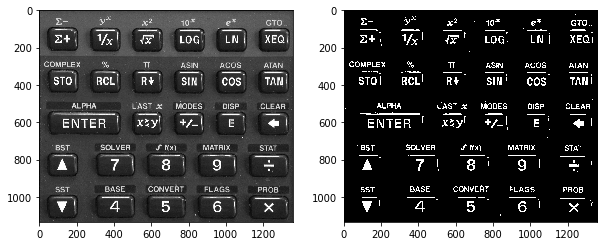

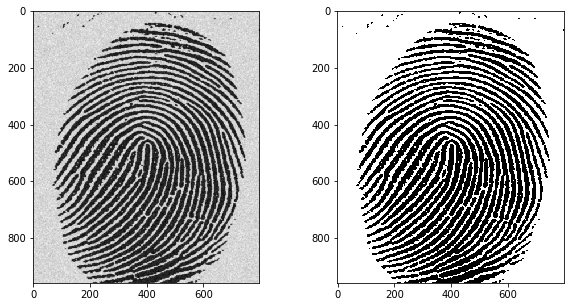

In [13]:
def otsu_thresholding(im: np.ndarray) -> int:
    # Compute normalized histogram
    hist, bins = np.histogram(image[:,:], 256)
    normal_hist = hist/np.sum(hist)
    #Compute cumulative sum
    
    #Then we calculate the cumulative histogram
    cumulative_hist = np.zeros((256), dtype = np.int)
    cumulative_hist[0] = hist[0]
    for i in range(1, 256):
        cumulative_hist[i] = cumulative_hist[i-1] + hist[i]

    #Compute cumulative means
    cum_mean = np.zeros(256)
    total = 0
    for i in range(256):
        total += (i+1)*normal_hist[i]
        cum_mean[i] = total
    #Compute global mean
    glob_mean = cum_mean[-1]
    
    #Compute between-class variance
    variance = np.zeros(256)
    for k in range(256):
        if(cumulative_hist[k]>0 and cumulative_hist[k]<1):
            variance[k] = (glob_mean*cumulative_hist[k] - cum_mean[k])**2
            variance[k] /= (cumulative_hist[k]*(1-cumulative_hist[k]))
    
    #Compute otsu threshold
    threshold = 0
    equalThresholds = [0] #If multiple thresholds have the same variance, calculate mean
    for i in range(1, 256):
        if variance[i]>variance[threshold]:
            threshold = i
            equalThresholds = [i]
        elif variance[i] == variance[threshold]:
            equalThresholds.append(i)
    threshold = np.mean(equalThresholds)
    return threshold


def threshold_image(image_path):
    image = plt.imread(image_path)
    threshold = otsu_thresholding(image)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(image>=threshold, cmap = "gray")
    plt.show()
    
threshold_image("images/calculator.tif")   
threshold_image("images/fingerprint.tif")



